# Thème 3: Aménagement cyclable/apaisement

**Analyse carto** : concentration point rouge x croisement carto accidento DSR 
- Identifier le top 10 des carrefours les plus dangereux en France selon les cyclistes (Tâche)
- % des points rouges du baromètre se situant à moins de 50 m d’un lieu où s’est produit une collision (Tâche)

> Hypothèse à valider ou pas : les lieux les moins cyclables sont également les lieux plus mortels pour les usagers de l’espace public 


## Config & modules

### 1 - Python stuffs

In [1]:
import os
import math
import boto3
import pandas as pd
from io import StringIO
import geopandas as gpd
from dotenv import load_dotenv
import contextily as ctx
from textwrap import fill
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Configs
_ = plt.style.use("ggplot")

### 2 - Personnal S3 module

In [2]:
class S3Manager:
    load_dotenv()
    def __init__(self, region="eu-west-3"):
        self.s3 = boto3.client(
            service_name="s3",
            region_name="PAR",
            endpoint_url=os.getenv("S3_ENDPOINT"),
            aws_access_key_id=os.getenv("SCW_ACCESS_KEY"),
            aws_secret_access_key=os.getenv("SCW_SECRET_KEY")
        )

    def list_bucket_contents(self, bucket_name):
        try:
            result = self.s3.list_objects_v2(Bucket=bucket_name)
            if "Contents" in result:
                print("Voici les objets présents dans le bucket :")
                for obj in result["Contents"]:
                    print(f"- {obj['Key']}")
            else:
                print("Le bucket est vide ou inaccessible.")
        except Exception as e:
            print(f"❌ Erreur lors de la lecture du bucket : {e}")

    def load_geojson_from_s3(self, bucket_name, s3_key):
        try:
            response = self.s3.get_object(Bucket=bucket_name, Key=s3_key)
            geojson_data = response['Body'].read().decode('utf-8')

            gtp_commune_m = gpd.read_file(StringIO(geojson_data))

            print("✅ Fichier chargé et converti en GeoDataFrame avec succès")
            return gtp_commune_m
        except Exception as e:
            print(f"❌ Erreur lors du chargement ou de la conversion du fichier GeoJSON: {e}")
            return None

    def download_from_s3(self, bucket_name, s3_key, download_path):
        try:
            with open(download_path, 'wb') as f:
                self.s3.download_fileobj(bucket_name, s3_key, f)
            print(f'✅ Fichier téléchargé depuis S3 : {download_path}')
        except Exception as e:
            print(f"❌ Erreur lors du téléchargement du fichier depuis S3: {e}")

    def delete_from_s3(self, bucket_name, s3_key):
        try:
            self.s3.delete_object(Bucket=bucket_name, Key=s3_key)
            print(f"✅ Fichier supprimé avec succès : {s3_key}")
        except Exception as e:
            print(f"❌ Erreur lors de la suppression du fichier depuis S3: {e}")

    def upload_to_s3(self, bucket_name, file_path, s3_key):
        try:
            with open(file_path, "rb") as f:
                self.s3.upload_fileobj(f, bucket_name, s3_key)
            print(f"✅ Fichier uploadé avec succès : {s3_key}")
        except Exception as e:
            print(f"❌ Erreur lors de l'upload du fichier vers S3: {e}")

## 1 - Récupération des données et découverte des données

In [3]:
# Chargement des éléments de connexion sur S3
s3_manager = S3Manager()
bucket = "fub-s3"

### 1.1 - Fichier --> données-carto-2025-06-03

In [4]:
# Données données internes
gdf = s3_manager.load_geojson_from_s3(bucket, "data/DFG/2025/data_geo/données-carto-2025-06-03.geojson")

✅ Fichier chargé et converti en GeoDataFrame avec succès


In [5]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1123765 entries, 0 to 1123764
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype   
---  ------       --------------    -----   
 0   uid          1123765 non-null  object  
 1   cat          1123765 non-null  int32   
 2   uid_reponse  1123765 non-null  object  
 3   description  837328 non-null   object  
 4   geometry     1123765 non-null  geometry
dtypes: geometry(1), int32(1), object(3)
memory usage: 38.6+ MB


In [6]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

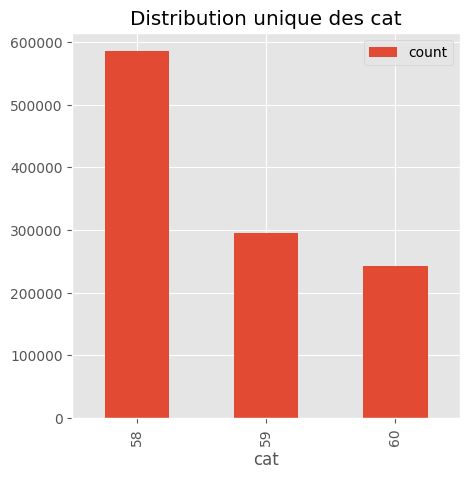

In [7]:
_ = pd.DataFrame({
    "count": gdf["cat"].value_counts().sort_index(),
}).plot(kind="bar", figsize=(5, 5), title="Distribution unique des cat")


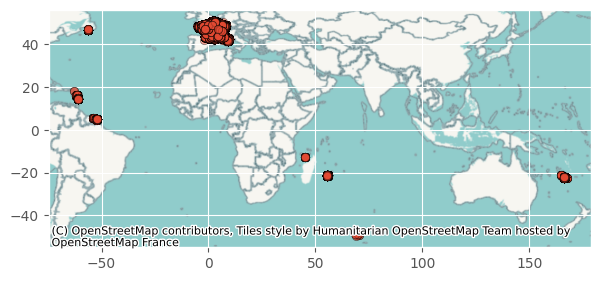

In [8]:
fig, ax = plt.subplots(figsize=(7, 7))
gdf.plot(ax=ax, alpha=0.5, edgecolor='k')
_ = ctx.add_basemap(ax, crs=gdf.crs.to_string())
plt.show()

> Anomalie spatiale : parti pris de recentrer les infos sur la France métropolitaine; <br/>
> Charggement du contour de la France pour éviter l'anomalie spatiale

In [9]:
url_contour_france = "https://france-geojson.gregoiredavid.fr/repo/departements.geojson"
contour_france = gpd.read_file(url_contour_france)
contour_france.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
contour_france.head()

code           nom                                           geometry
0   02         Aisne  POLYGON ((3.1727 50.012, 3.1822 50.01234, 3.21...
1   10          Aube  POLYGON ((3.41479 48.39027, 3.42208 48.41334, ...
2   14      Calvados  POLYGON ((-1.11962 49.35557, -1.11503 49.3624,...
3   15        Cantal  POLYGON ((2.50841 45.4785, 2.52444 45.4807, 2....
4   28  Eure-et-Loir  POLYGON ((0.81482 48.67016, 0.82767 48.68072, ...

In [11]:
gdf = gdf.to_crs(contour_france.crs)
gdf_filtre = gpd.sjoin(gdf, contour_france, predicate="within", how="inner")
gdf_filtre = gdf_filtre.drop(columns=["index_right"])

In [12]:
gdf_filtre.head()

uid  cat  \
0  dd441ba7-d3a7-490e-8cfe-1d34e4a09311   58   
1  63ef8e40-8be8-4362-b9ea-5b38a0347ef3   59   
2  899273c7-bdec-4e6b-a7bb-f81dd8b2e2cf   59   
3  7818ede4-4bc5-4681-b603-d9799ee57ba9   59   
4  384f138d-551f-48cb-a8e6-7545a3486eed   58   

                            uid_reponse  \
0  ffde2d2e-fa32-4bbb-a7f2-f94300dfb19d   
1  ffde2d2e-fa32-4bbb-a7f2-f94300dfb19d   
2  ffde2d2e-fa32-4bbb-a7f2-f94300dfb19d   
3  ffde2d2e-fa32-4bbb-a7f2-f94300dfb19d   
4  9ead1f87-7e1e-4c88-8044-567f871bca5d   

                                         description  \
0                   Route trop étroite et dangereuse   
1                                   Maison de santé    
2                                     Centre social    
3                                      Centre ville    
4  pas de piste cyclable ; stationnement de voitu...   

                   geometry code        nom  
0   POINT (4.47109 47.1244)   21  Côte-d'Or  
1  POINT (4.48483 47.13117)   21  Côte-d'Or  
2  POINT (4.49131 47.13086)   21  Côte-d'Or  
3  POINT (4.48614 47.13059)   21  Côte-d'Or  
4  POINT (3.07002 50.60544)   59       Nord

In [13]:
gdf_filtre.shape

(1107107, 7)

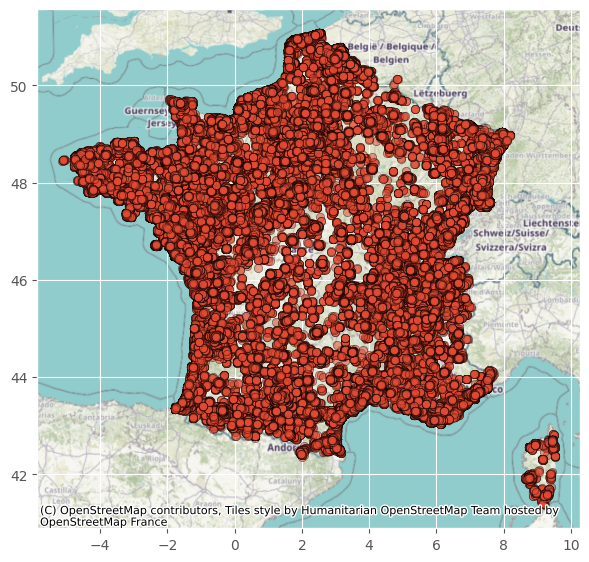

In [14]:
fig, ax = plt.subplots(figsize=(7, 7))
gdf_filtre.plot(ax=ax, alpha=0.5, edgecolor='k')
_ = ctx.add_basemap(ax, crs=gdf_filtre.crs.to_string())
plt.show()

> Filtrer les données sur la catégorie d'analyse qui est la réponse à la question <br/>
> **"Cliquez sur la carte pour indiquer les 3 endroits les plus problématiques pour se déplacer à vélo."**

In [15]:
gdf_58 = gdf[gdf["cat"] == 58] 
gdf_58.head()

uid  cat  \
0   dd441ba7-d3a7-490e-8cfe-1d34e4a09311   58   
4   384f138d-551f-48cb-a8e6-7545a3486eed   58   
5   11a588e4-9976-4971-9212-e7f56138125e   58   
6   ecabf7ab-93a8-4681-9937-8afe5d00f60c   58   
11  261dbaa4-2555-40b2-a627-cb7c0d947172   58   

                             uid_reponse  \
0   ffde2d2e-fa32-4bbb-a7f2-f94300dfb19d   
4   9ead1f87-7e1e-4c88-8044-567f871bca5d   
5   9ead1f87-7e1e-4c88-8044-567f871bca5d   
6   9ead1f87-7e1e-4c88-8044-567f871bca5d   
11  d9bfec3d-fef7-47c9-b949-60964467556f   

                                          description  \
0                    Route trop étroite et dangereuse   
4   pas de piste cyclable ; stationnement de voitu...   
5   espace piste vélo et voiture non suffisante ; ...   
6            Pas de piste cyclable sur le croisement    
11                                                      

                    geometry  
0    POINT (4.47109 47.1244)  
4   POINT (3.07002 50.60544)  
5   POINT (3.07154 50.60737)  
6   POINT (3.07128 50.60678)  
11  POINT (2.31102 48.81624)

In [16]:
gdf_58.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 585174 entries, 0 to 1123764
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   uid          585174 non-null  object  
 1   cat          585174 non-null  int32   
 2   uid_reponse  585174 non-null  object  
 3   description  449267 non-null  object  
 4   geometry     585174 non-null  geometry
dtypes: geometry(1), int32(1), object(3)
memory usage: 24.6+ MB


### 1.2 - Fichier --> 3.F.BAAC_2023_2014

In [17]:
# Enrichissement des données avec les accidents
s3_manager.download_from_s3(bucket, "data/DFG/2025/data_geo/externe/3.F.BAAC_2023_2014(1).xlsx", download_path="temp/accidents-old.xlsx")
# accidents = pd.read_excel("temp/accidents.xlsx") # --> REPRENDRE MES ELEMENTS
accidents = pd.read_excel("temp/accidents.xlsx") # --> Nouvel export de https://www.onisr.securite-routiere.gouv.fr/recherche-statistique-des-accidents

✅ Fichier téléchargé depuis S3 : temp/accidents-old.xlsx


In [18]:
accidents.head()

Dépt                           Commune                Date  Tué(s)  Blessés  \
0   34                   34032 - Béziers  01/01/2023 - 00h00       0        5   
1   17                   17133 - Cravans  01/01/2023 - 00h09       1        0   
2   11               11069 - Carcassonne  01/01/2023 - 00h15       1        0   
3   75  75119 - Paris 19e Arrondissement  01/01/2023 - 00h25       0        1   
4   38         38507 - Tignieu-Jameyzieu  01/01/2023 - 00h30       0        3   

   dont hospitalisés  dont légers              Milieu Autoroute  \
0                  4            1  Hors agglomération       Non   
1                  0            0    En agglomération       Non   
2                  0            0    En agglomération       Non   
3                  0            1    En agglomération       Non   
4                  1            2    En agglomération       Non   

                          Adresse Latitude Longitude  \
0                             D14    3,188    43,309   
1  25 Route de la Grande Mercerie   -0,719    45,599   
2                         RD 6113    2,342     43,23   
3               Avenue de Flandre    2,379    48,892   
4                Route de Crémieu    5,184     45,75   

                                              Résumé  
0  Accident Grave non mortel, Hors agglomération,...  
1  Accident Mortel, En agglomération, Hors inters...  
2  Accident Mortel, En agglomération, Hors inters...  
3  Accident Léger non mortel, En agglomération, E...  
4  Accident Grave non mortel, En agglomération, A...

In [19]:
accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Dépt               3000 non-null   object
 1   Commune            3000 non-null   object
 2   Date               3000 non-null   object
 3   Tué(s)             3000 non-null   int64 
 4   Blessés            3000 non-null   int64 
 5   dont hospitalisés  3000 non-null   int64 
 6   dont légers        3000 non-null   int64 
 7   Milieu             3000 non-null   object
 8   Autoroute          3000 non-null   object
 9   Adresse            2912 non-null   object
 10  Latitude           3000 non-null   object
 11  Longitude          3000 non-null   object
 12  Résumé             3000 non-null   object
dtypes: int64(4), object(9)
memory usage: 304.8+ KB


In [20]:
accidents[accidents["Latitude"].isna() | accidents["Longitude"].isna()]

Empty DataFrame
Columns: [Dépt, Commune, Date, Tué(s), Blessés, dont hospitalisés, dont légers, Milieu, Autoroute, Adresse, Latitude, Longitude, Résumé]
Index: []

> Alerte géo : 1485 données ne sont mas géolocalisés dans l'ancien fichier


In [21]:
# Nettoyage des données --> "," en "." pour la prise en compte des coordonnées dans la conversion en GeoDataFrame
accidents['Latitude'] = accidents['Latitude'].str.replace(',', '.').astype(float)
accidents['Longitude'] = accidents['Longitude'].str.replace(',', '.').astype(float)

In [22]:
accidents.rename(columns={
    'Latitude': 'Longitude_corrigée',
    'Longitude': 'Latitude_corrigée'
}, inplace=True)

In [23]:
accidents_geo = gpd.GeoDataFrame(
    accidents,
    geometry=gpd.points_from_xy(accidents['Longitude_corrigée'], accidents['Latitude_corrigée']),
    crs="EPSG:4326"
)

In [24]:
accidents_geo = accidents_geo.drop(columns=["Longitude_corrigée", "Latitude_corrigée"])
accidents_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Dépt               3000 non-null   object  
 1   Commune            3000 non-null   object  
 2   Date               3000 non-null   object  
 3   Tué(s)             3000 non-null   int64   
 4   Blessés            3000 non-null   int64   
 5   dont hospitalisés  3000 non-null   int64   
 6   dont légers        3000 non-null   int64   
 7   Milieu             3000 non-null   object  
 8   Autoroute          3000 non-null   object  
 9   Adresse            2912 non-null   object  
 10  Résumé             3000 non-null   object  
 11  geometry           3000 non-null   geometry
dtypes: geometry(1), int64(4), object(7)
memory usage: 281.4+ KB


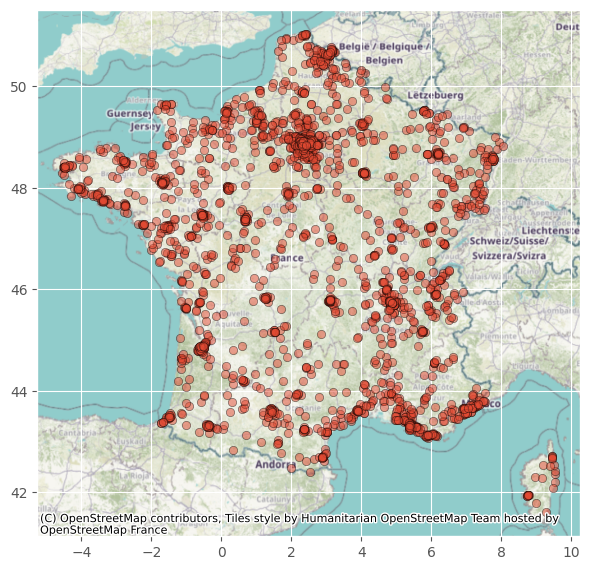

In [25]:
fig, ax = plt.subplots(figsize=(7, 7))
accidents_geo.plot(ax=ax, alpha=0.5, edgecolor='k')
_ = ctx.add_basemap(ax, crs=accidents_geo.crs.to_string())
plt.show()

In [26]:
accidents_geo_filtre = gpd.sjoin(accidents_geo, contour_france, predicate="within", how="inner")
accidents_geo_filtre = accidents_geo_filtre.drop(columns=["index_right"])

In [27]:
accidents_geo_filtre.shape

(2999, 14)

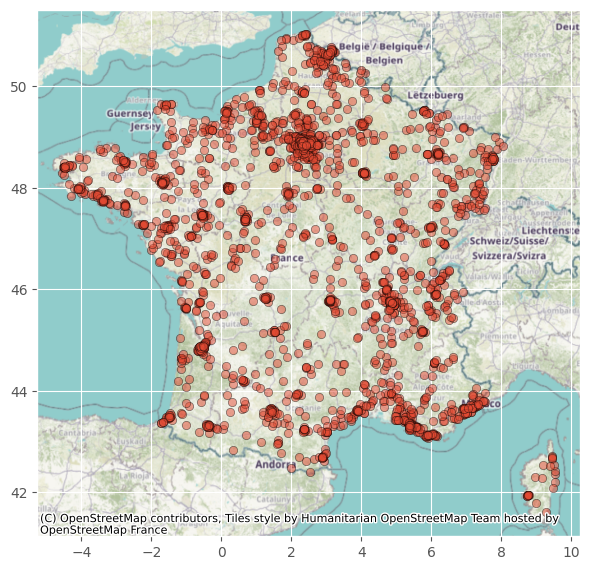

In [28]:
fig, ax = plt.subplots(figsize=(7, 7))
accidents_geo_filtre.plot(ax=ax, alpha=0.5, edgecolor='k')
_ = ctx.add_basemap(ax, crs=accidents_geo_filtre.crs.to_string())
plt.show()

## 2 - Repérage des carrefours les plus dangereux selon les cyclistes
> Méthodologie : l'idée ici est de voir les lieux où la concentration de points est la plus forte avec un rayon de 50m; <br/>
> on va appliquer le DBSCAN pour permettre ce clustering spatial sans trop de paramètre à gérer --> utilisation du log(n) pour définir le seuil de point

In [29]:
gdf_58_cluster = gdf_58.to_crs(2154).copy() 
print(f"La projection du GeoDataFrame est : {gdf_58_cluster.crs}")

La projection du GeoDataFrame est : EPSG:2154


In [30]:
min_sample = round(math.log(585174)) + 1
print(f"Le nombre minimal d'échantillons pour le clustering est : {min_sample}")

Le nombre minimal d'échantillons pour le clustering est : 14


In [31]:
dbscan = DBSCAN(eps=50, min_samples=min_sample, metric='euclidean')
dbscan.fit(gdf_58_cluster.geometry.apply(lambda geom: (geom.x, geom.y)).tolist())
gdf_58_cluster["cluster_id"] = dbscan.labels_

In [32]:
gdf_58_cluster.sort_values(by="cluster_id", ascending=False).head()

uid  cat  \
169890  99510335-bf34-48c4-aeaa-fce1a72b68a2   58   
442672  1e9af362-a049-4b22-af69-630372bce518   58   
724733  0a4c9346-7d68-4908-a6ea-4b8d545a8f08   58   
860405  0eccc7c1-a043-4e8e-b294-5c16c6ac3fd4   58   
955716  04addd68-e720-4ca4-8aa7-965cdd79d927   58   

                                 uid_reponse  \
169890  f3cd0e79-301d-4846-9f7d-c43b8b096f25   
442672  2795cb8b-e917-48ae-9f79-336774a1ba13   
724733  d660087e-ebc2-40aa-96e0-87538a7172f8   
860405  f99a37d2-1941-4736-b99d-6dccc48d23f9   
955716  5754612b-2f1f-49e1-880e-49166e5db33b   

                                              description  \
169890                                               None   
442672  Arret brutal de vehicles cherchant un stationn...   
724733                                       pointe rouge   
860405                                               None   
955716                                                      

                              geometry  cluster_id  
169890  POINT (893009.902 6242059.096)        2560  
442672  POINT (893017.163 6242119.608)        2560  
724733  POINT (893004.275 6242117.267)        2560  
860405  POINT (893009.584 6242043.003)        2560  
955716  POINT (893013.331 6242068.581)        2560

In [33]:
print(f"Nombre de clusters identifiés : {gdf_58_cluster.cluster_id.nunique()}") # Raisonnable pour 585174 ligne de données

Nombre de clusters identifiés : 2562


In [34]:
# Compte des points par cluster (en excluant le bruit)
cluster_counts = (
    gdf_58_cluster.loc[gdf_58_cluster["cluster_id"] != -1]
    .groupby("cluster_id")
    .size()
    .reset_index(name="nb_points")
)

In [35]:
# Top 10 clusters les plus gros
top_clusters = cluster_counts.sort_values("nb_points", ascending=False).head(10)
top_clusters

cluster_id  nb_points
52           52       1638
196         196       1509
202         202        992
43           43        732
29           29        689
87           87        660
94           94        568
142         142        528
169         169        527
598         598        514

In [36]:
top_points = gdf_58_cluster.merge(top_clusters, on="cluster_id")
top_points.head()

uid  cat  \
0  3e8aa7e3-e6d0-425a-b280-06a6098981a9   58   
1  93126fb2-04fc-48b5-977b-307e04a5db18   58   
2  7b63a8ee-c225-49be-8cef-87c4b3a6adfe   58   
3  0137d657-ef71-407b-8a8e-acc14aae38ba   58   
4  cf512720-eccd-415e-93ce-fb256d2b7918   58   

                            uid_reponse  \
0  fc1e1598-394c-48eb-8fc6-4e6bc68aef93   
1  7a95174e-a7c6-4847-a62e-0a46dc2765cc   
2  4954d2a0-7e3a-4ce6-baca-bd9615efbc83   
3  53ad1308-696d-4fc7-b630-66c67a6ce519   
4  2abb19e8-568d-4812-9b71-a09a31bfe9ba   

                                         description  \
0                               Place marcel sembat    
1  Piste cyclables du Prado partage avec les piét...   
2                                                      
3      Berthelot, éternetl point noir des cyclistes.   
4                                               None   

                         geometry  cluster_id  nb_points  
0  POINT (644571.508 6859617.145)          29        689  
1  POINT (893877.518 6245127.528)          43        732  
2   POINT (653356.176 6863220.06)          52       1638  
3   POINT (843095.601 6517889.46)          87        660  
4  POINT (650335.719 6863311.955)          94        568

In [37]:
# Récupération par communes
communes = gpd.read_file("https://france-geojson.gregoiredavid.fr/repo/communes.geojson")
communes = communes.to_crs(4326)
top_points_communes = top_points.to_crs(epsg=4326)

In [38]:
print(f"Vérification CRS {communes.crs} et {top_points_communes.crs}")
tp_communes = top_points_communes.sjoin(communes, predicate="within", how="inner")
tp_communes.head()

Vérification CRS EPSG:4326 et EPSG:4326


uid  cat  \
0  3e8aa7e3-e6d0-425a-b280-06a6098981a9   58   
1  93126fb2-04fc-48b5-977b-307e04a5db18   58   
2  7b63a8ee-c225-49be-8cef-87c4b3a6adfe   58   
3  0137d657-ef71-407b-8a8e-acc14aae38ba   58   
4  cf512720-eccd-415e-93ce-fb256d2b7918   58   

                            uid_reponse  \
0  fc1e1598-394c-48eb-8fc6-4e6bc68aef93   
1  7a95174e-a7c6-4847-a62e-0a46dc2765cc   
2  4954d2a0-7e3a-4ce6-baca-bd9615efbc83   
3  53ad1308-696d-4fc7-b630-66c67a6ce519   
4  2abb19e8-568d-4812-9b71-a09a31bfe9ba   

                                         description  \
0                               Place marcel sembat    
1  Piste cyclables du Prado partage avec les piét...   
2                                                      
3      Berthelot, éternetl point noir des cyclistes.   
4                                               None   

                   geometry  cluster_id  nb_points  index_right   code  \
0  POINT (2.24489 48.83422)          29        689        31162  92012   
1   POINT (5.3874 43.27894)          43        732         1768  13208   
2  POINT (2.36416 48.86732)          52       1638        14380  75111   
3  POINT (4.84061 45.74559)          87        660        22318  69387   
4  POINT (2.32298 48.86792)          94        568        13178  75108   

                            nom  
0          Boulogne-Billancourt  
1  Marseille 8e  Arrondissement  
2     Paris 11e  Arrondissement  
3       Lyon 7e  Arrondissement  
4      Paris 8e  Arrondissement

In [39]:
graph_top_commune = tp_communes.copy()
graph_top_commune = graph_top_commune[["cluster_id", "nom", "geometry", "nb_points", "description", "uid"]]
graph_top_commune

cluster_id                           nom                  geometry  \
0             29          Boulogne-Billancourt  POINT (2.24489 48.83422)   
1             43  Marseille 8e  Arrondissement   POINT (5.3874 43.27894)   
2             52     Paris 11e  Arrondissement  POINT (2.36416 48.86732)   
3             87       Lyon 7e  Arrondissement  POINT (4.84061 45.74559)   
4             94      Paris 8e  Arrondissement  POINT (2.32298 48.86792)   
...          ...                           ...                       ...   
8352          94      Paris 8e  Arrondissement  POINT (2.31846 48.86462)   
8353          94      Paris 8e  Arrondissement  POINT (2.32116 48.86551)   
8354          87       Lyon 7e  Arrondissement  POINT (4.83415 45.74757)   
8355          43  Marseille 6e  Arrondissement  POINT (5.38576 43.28654)   
8356          43  Marseille 6e  Arrondissement  POINT (5.38537 43.28298)   

      nb_points                                        description  \
0           689                               Place marcel sembat    
1           732  Piste cyclables du Prado partage avec les piét...   
2          1638                                                      
3           660      Berthelot, éternetl point noir des cyclistes.   
4           568                                               None   
...         ...                                                ...   
8352        568  Croisement dangereux entre les deux voies de l...   
8353        568  Trop d occupation de la place pour des événeme...   
8354        660   Absence de bande cyclable sur l'avenue Berthelot   
8355        732  Arrivée  de la piste cyclable de lieutaid sur ...   
8356        732  Axe majeur sans piste cyclable sécurisée ni si...   

                                       uid  
0     3e8aa7e3-e6d0-425a-b280-06a6098981a9  
1     93126fb2-04fc-48b5-977b-307e04a5db18  
2     7b63a8ee-c225-49be-8cef-87c4b3a6adfe  
3     0137d657-ef71-407b-8a8e-acc14aae38ba  
4     cf512720-eccd-415e-93ce-fb256d2b7918  
...                                    ...  
8352  5ae3ad66-f880-4ab3-b5d7-36a8ada6d793  
8353  da9c540d-c923-4882-8970-b0ca53a717ef  
8354  7d2d7eaa-ca26-4cc0-b40c-d756b0ce663a  
8355  1fa9753a-901d-4302-bba0-b076756ff786  
8356  ad69741f-65f2-45ad-8044-aaa0c8dc3ebd  

[8357 rows x 6 columns]

In [40]:
# Graphique d'aperçu des cluster + référence spatiales (communes)
tp_commune_m = (
    graph_top_commune
    .groupby(["cluster_id"])
    .agg(nom=("nom", lambda x: ",".join(sorted(set(x)))), nb_points=("nb_points", "first"))
    .reset_index()
)
tp_commune_m = tp_commune_m.rename(columns={"nom": "communes"})
tp_commune_m["communes"] = tp_commune_m["communes"].str.replace("Arrondissement", "")
tp_commune_m["communes"] = tp_commune_m["communes"].str.replace("  ,", "|")
tp_commune_m.sort_values(by="nb_points", ascending=False)

cluster_id                                           communes  nb_points
2          52  Paris 10e|Paris 11e|Paris 18e|Paris 3e|Paris 9e         1638
7         196  Paris 10e|Paris 1er ,Paris 2e|Paris 3e|Paris 4e         1509
8         202                     Paris 11e|Paris 12e|Paris 4e          992
1          43                        Marseille 6e|Marseille 8e          732
0          29                               Boulogne-Billancourt        689
3          87                                  Lyon 7e|Lyon 8e          660
4          94                              Paris 1er ,Paris 8e          568
5         142                                             Nantes        528
6         169                          Lyon 2e|Lyon 3e|Lyon 7e          527
9         598                                          Montreuil        514

In [41]:
tp_commune_m.sort_values(by="nb_points", ascending=False, inplace=True)
def wrap_label(s, width=36):
    return fill(s.replace("|", " | "), width=width)

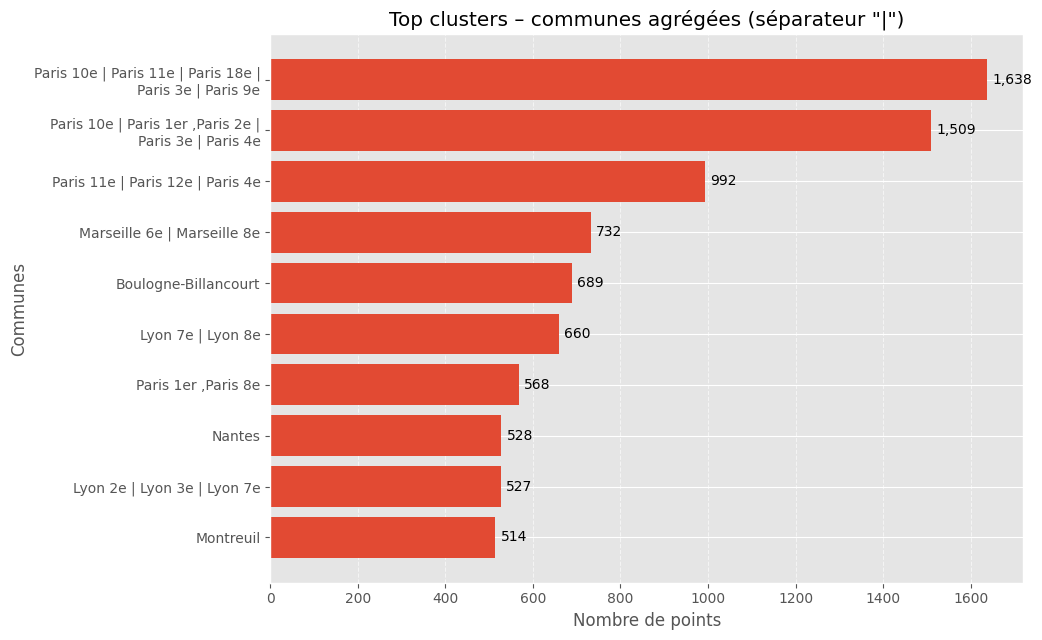

In [42]:
tp_commune_m["communes_wrapped"] = tp_commune_m["communes"].apply(lambda s: wrap_label(s, width=38))


fig, ax = plt.subplots(figsize=(10.5, 6.5))
bars = ax.barh(tp_commune_m["communes_wrapped"], tp_commune_m["nb_points"])
ax.invert_yaxis()
for bar, value in zip(bars, tp_commune_m["nb_points"]):
    ax.text(
        value + 12,
        bar.get_y() + bar.get_height() / 2,
        f"{value:,}",
        va="center",
        fontsize=10,
    )


ax.set_title("Top clusters – communes agrégées (séparateur \"|\")")
ax.set_xlabel("Nombre de points")
ax.set_ylabel("Communes", fontsize=12)
ax.grid(axis="x", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

In [43]:
tp_commune_m = tp_commune_m.merge(tp_communes, on="cluster_id")
tp_commune_m = gpd.GeoDataFrame(tp_commune_m)

In [44]:
tp = tp_communes.to_crs(4326).copy()
tp["lon"] = tp.geometry.x
tp["lat"] = tp.geometry.y

fig = px.scatter_map(
    tp,
    lat="lat",
    lon="lon",
    color="nb_points",
    hover_data={
        "uid": True, 
        "description": True, 
        "cluster_id": True, 
        "lat": False, "lon": False
    },
    opacity=0.6,
    height=700,
    width=700,
    zoom=4,  
)

fig.update_traces(marker={"size": 10})
fig.update_layout(
    mapbox_style="open-street-map",
    margin=dict(l=0, r=0, t=40, b=0),
    legend_title_text="Cluster ID",
    title="Top clusters – communes – vue interactive",
)

fig.show()

In [45]:
cluster_52 = tp_communes[tp_communes["cluster_id"] == 52]
tp = cluster_52.to_crs(4326).copy()
tp["lon"] = tp.geometry.x
tp["lat"] = tp.geometry.y

fig = px.scatter_map(
    tp,
    lat="lat",
    lon="lon",
    color="nb_points",
    hover_data={
        "uid": True, 
        "description": True, 
        "cluster_id": True, 
        "lat": False, "lon": False
    },
    opacity=0.6,
    height=700,
    width=700,
    zoom=14,  
)

fig.update_traces(marker={"size": 10})
fig.update_layout(
    mapbox_style="open-street-map",
    margin=dict(l=0, r=0, t=40, b=0),
    legend_title_text="Cluster ID",
    title="Cluster_52 – vue interactive",
)

fig.show()

In [46]:
cluster_196 = tp_communes[tp_communes["cluster_id"] == 196]
tp = cluster_196.to_crs(4326).copy()
tp["lon"] = tp.geometry.x
tp["lat"] = tp.geometry.y

fig = px.scatter_map(
    tp,
    lat="lat",
    lon="lon",
    color="nb_points",
    hover_data={
        "uid": True, 
        "description": True, 
        "cluster_id": True, 
        "lat": False, "lon": False
    },
    opacity=0.6,
    height=700,
    width=700,
    zoom=14,  
)

fig.update_traces(marker={"size": 10})
fig.update_layout(
    mapbox_style="open-street-map",
    margin=dict(l=0, r=0, t=40, b=0),
    legend_title_text="Cluster ID",
    title="Cluster_196 – vue interactive",
)

fig.show()

In [47]:
cluster_202 = tp_communes[tp_communes["cluster_id"] == 202]
tp = cluster_202.to_crs(4326).copy()
tp["lon"] = tp.geometry.x
tp["lat"] = tp.geometry.y

fig = px.scatter_map(
    tp,
    lat="lat",
    lon="lon",
    color="nb_points",
    hover_data={
        "uid": True, 
        "description": True, 
        "cluster_id": True, 
        "lat": False, "lon": False
    },
    opacity=0.6,
    height=700,
    width=700,
    zoom=18,  
)

fig.update_traces(marker={"size": 10})
fig.update_layout(
    mapbox_style="open-street-map",
    margin=dict(l=0, r=0, t=40, b=0),
    legend_title_text="Cluster ID",
    title="Cluster_202 – vue interactive",
)

fig.show()

In [48]:
cluster_29 = tp_communes[tp_communes["cluster_id"] == 29]
tp = cluster_29.to_crs(4326).copy()
tp["lon"] = tp.geometry.x
tp["lat"] = tp.geometry.y

fig = px.scatter_map(
    tp,
    lat="lat",
    lon="lon",
    color="nb_points",
    hover_data={
        "uid": True, 
        "description": True, 
        "cluster_id": True, 
        "lat": False, "lon": False
    },
    opacity=0.6,
    height=700,
    width=700,
    zoom=18,  
)

fig.update_traces(marker={"size": 10})
fig.update_layout(
    mapbox_style="open-street-map",
    margin=dict(l=0, r=0, t=40, b=0),
    legend_title_text="Cluster ID",
    title="Cluster_29 – vue interactive",
)

fig.show()

## 3 - Pourcentage des points rouges du baromètre se situant à moins de 50 m d’un lieu où s’est produit une collision 

### 3.1 - Statistique nationnale

In [49]:
# Reprojection pour avoir des distances en "m"
gdf58_2154 = gdf_58.to_crs(2154).copy()
acc_2154 = accidents_geo_filtre.to_crs(2154).copy()

In [50]:
# Jointure par proximité à 50 m
merged_2154 = gpd.sjoin_nearest(
    gdf58_2154, #contrib
    acc_2154, # accidents
    how="left",
    max_distance=50,
    lsuffix="velo",
    rsuffix="acc",
    distance_col="dist_m"
)

In [51]:
# calcul du % de points rouges
pct_points_couverts = 100 * merged_2154[merged_2154["index_acc"].notnull()].shape[0] / merged_2154.shape[0]
print(f"Pourcentage de points rouges avec un accident à moins de 50 m : {pct_points_couverts:.2f}% soit {merged_2154[merged_2154['index_acc'].notnull()].shape[0]} points.")

Pourcentage de points rouges avec un accident à moins de 50 m : 1.21% soit 7109 points.


### 3 - Statistiques par communes

In [55]:
merged_stat = merged_2154.copy()
merged_stat["Commune"] = merged_stat["Commune"].str.split(" - ").str[1]

In [56]:
top_10_com = (
    merged_stat.groupby("Commune")
    .agg(nb_points=("uid","nunique"))  # = nb de lignes
    .sort_values("nb_points", ascending=False).head(10)
)
top_10_com

nb_points
Commune                                
Paris 1er Arrondissement            457
Paris 10e Arrondissement            430
Boulogne-Billancourt                361
Paris 19e Arrondissement            294
Marseille 1er Arrondissement        250
Angers                              211
Paris 2e Arrondissement             187
Paris 8e Arrondissement             140
Paris 9e Arrondissement             129
Rennes                              114

In [57]:
top_10_com["nb_points"] = top_10_com["nb_points"] / merged_2154.shape[0] * 100

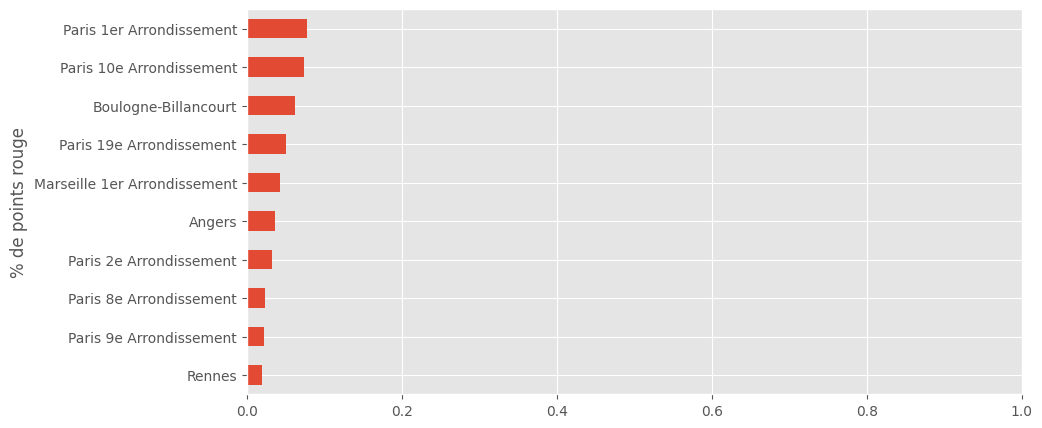

In [58]:
_ = top_10_com.sort_values(
    "nb_points", 
    ascending=True
    ).plot(
        kind="barh", 
        figsize=(10, 5), 
        # title="Top 10 des départements en %",
        legend=False,
        ylabel="% de points rouge",
        xlim=(0, 1)
    )

## 4 - Tests statistiques